In [1]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp

import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_calcium_base as pl
import spatial_metrics.spatial_metrics_calcium_binarized_base as pl_bin
import spatial_metrics.spatial_metrics_spikes_base as pl_spk



In [ ]:
# shifting time should be significantly lower 

In [ ]:

srate = 30. # points/frames per second
total_Time = 1000 # in seconds
_lambda = 10 # how much your neuron should spike
environment_edges = [[0,100],[0,100]] # in cm [[x1,x2],[y1,y2]]

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_random_walk(input_srate = srate,input_total_Time = total_Time,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = timevector.shape[0]


timestamps = cs_model.generate_arrivals(_lambda,total_Time)
I_timestamps = (timestamps*srate).astype(int)
print(I_timestamps.shape)
# place cell with one field: x_center and y_center is the location of the place field in the environment; s is the field extension
modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 35,y_center = 25, s = 10)

calcium_imag,timevector = cs_model.generate_calcium_signal(modulated_timestamps,total_points,srate,noise_level = 0.01, b = 5.)
calcium_events = modulated_timestamps.shape[0]
I_peaks = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))


# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
srate = 1/np.nanmean(np.diff(timevector))

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 2 # y bin size in cm
input_dict['y_bin_size'] = 2 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shift_time'] = 20
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 100
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['smoothing_size'] = 4
input_dict['nbins_cal'] = 10

place_cell = pl.PlaceCell(**input_dict)

place_cell_output = place_cell.main(calcium_imag,timevector,x_coordinates,y_coordinates)


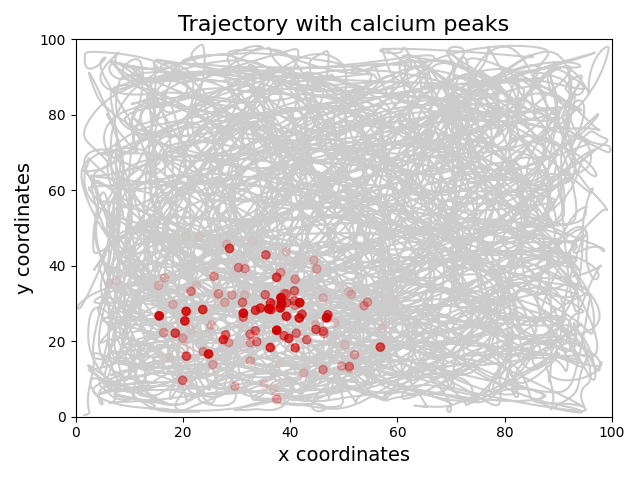

In [43]:

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


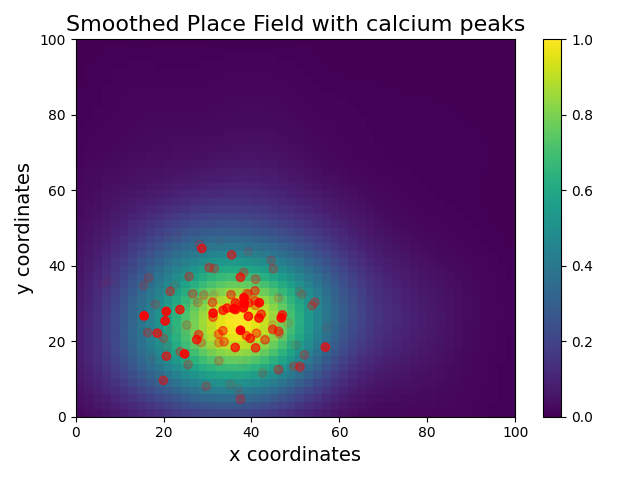

In [44]:

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


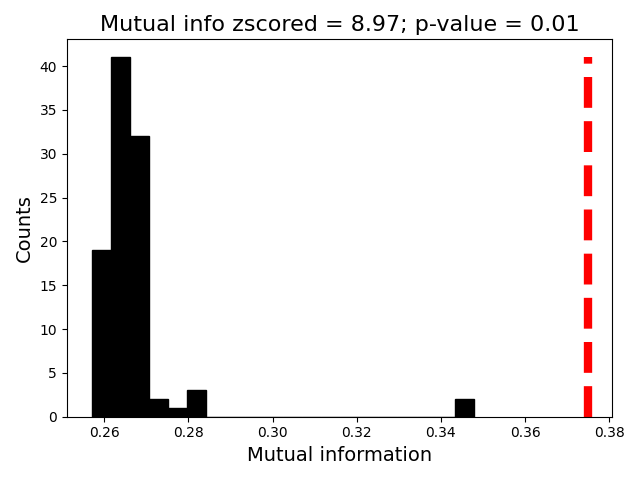

In [53]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shuffled'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Mutual information',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


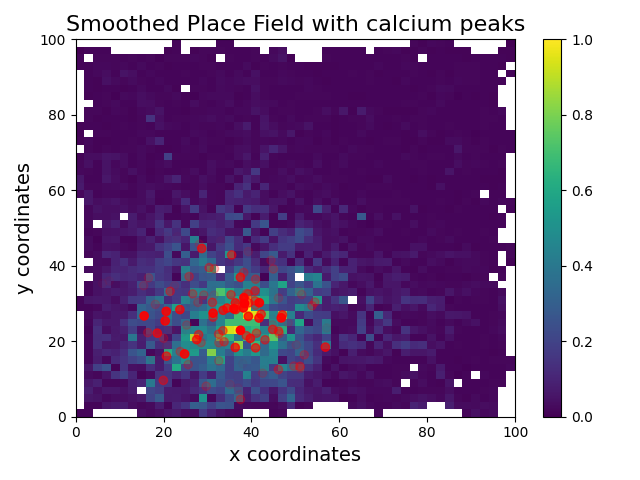

In [47]:
x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['signal_map'])
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


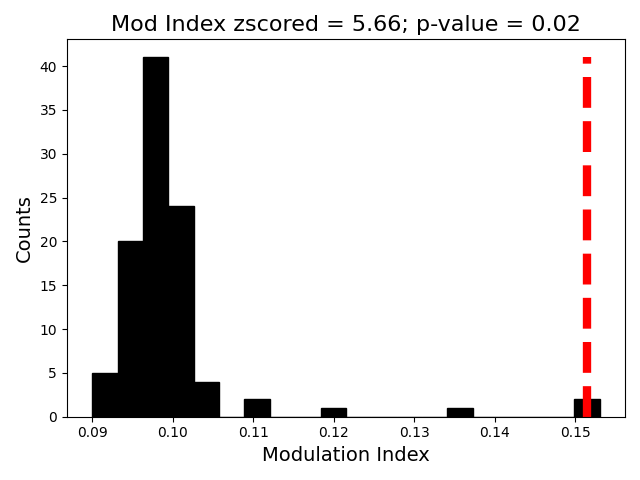

In [46]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['kullback_leibler_mod_index_shuffled'] >= place_cell_output['kullback_leibler_mod_index'])/place_cell_output['kullback_leibler_mod_index_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['kullback_leibler_mod_index_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['kullback_leibler_mod_index_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['kullback_leibler_mod_index'],place_cell_output['kullback_leibler_mod_index']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mod Index zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['kullback_leibler_mod_index_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()
